# Introduction to machine learning and scikit-learn

Congratulations -- we're almost to the end of the course! By this point, we've learned how to load EEG and task events, extract spectral power, and run univariate statistics to correlate spectral power with episodic memory. But there's also a way to correlate memory with *entire patterns* of memory across frequency bands and electrodes. We generally call these "multivariate" methods, but these approaches are more commonly known as **machine learning**.

Don't be intimidated if you've never used machine learning algorithms before. They can actually be pretty intuitive -- once you get the hang of it and practice a bit -- and machine learning software packages are pretty mature. So it only takes a few lines of code to start implementing pretty powerful machine learning algorithms. 

**The Big Picture**: The big idea of machine learning is to discover patterns in data. In many ways, machine learning is just a more flexible and powerful way of doing statistics, in that it lets us interpret data as it relates to a real-world variable of interest. Most things called "machine learning" take observations of data (called **features**) and use them to make predictions about a variable of interest. In doing so, machine learning models find values for weights, or **parameters**, that can also be useful to data scientists. 

For example, last week we learned how to correlate power at specific frequencies and electrodes with subsequent memory. Machine-learning algorithms would let us use those same data to make explicit predictions about whether an item will be remembered, before we even ask the subject. 


## Linear Regression

Linear regression is the "simplest" kind of machine learning! Note that much of this lesson on linear regression and its text was sourced from: https://jakevdp.github.io/PythonDataScienceHandbook/05.02-introducing-scikit-learn.html

In [1]:
import seaborn as sns
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In machine learning, we call these tables **"feature matrices."** The *target array*, or set of values we'd like to predict, is often just called "y." For example, if we wanted to predict flower species from flower morphology, the species name would be the y vector.

In [2]:
#Construct a feature matrix without the species
X_iris = iris.drop('species', axis=1)

#Construct the y vector
Y_iris = iris['species']

print(X_iris.shape)

(150, 4)


<img src="https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.02-samples-features.png">

### Performing linear regression

1.**Choose a class of model**

In Scikit-Learn, every class of model is represented by a Python class. So, for example, if we would like to compute a simple linear regression model, we can import the linear regression class:

In [3]:
from sklearn.linear_model import LinearRegression

2.**Choose model hyperparameters**

An important point is that a class of model is not the same as an *instance* of a model.

Once we have decided on our model class, there are still some options open to us. Depending on the model class we are working with, we might need to answer one or more questions like the following:

* Would we like to fit for the offset (i.e., y-intercept)?
* Would we like the model to be normalized?
* Would we like to preprocess our features to add model flexibility?
* What degree of regularization would we like to use in our model?
* How many model components would we like to use?

These are examples of the important choices that must be made once the model class is selected. These choices are often represented as hyperparameters, or parameters that must be set before the model is fit to data. In Scikit-Learn, hyperparameters are chosen by passing values at model instantiation.

In [4]:
#We're setting the fit_intercept hyperparameter
model = LinearRegression(fit_intercept=True)
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

3.**Arrange data into feature matrix and target vector.**

(50, 1)


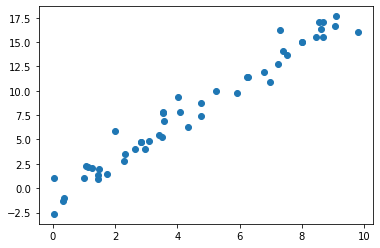

In [5]:
import numpy as np
import matplotlib.pyplot as plt

#Here, we're going to use synthesized data. Give some random data a slope of 2 and an intercept of -1, and add a bit of noise
x = 10 * np.random.rand(50)
y = 2 * x - 1 + np.random.randn(50)
plt.scatter(x, y);

#Technically, X needs to be an nx1 shaped array, so...
X = x[:, np.newaxis]
print(X.shape)

4.**Fit the model!**

In [6]:
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7]:
#Inspect the model parameters
print(model.coef_)
print(model.intercept_)

[1.95683382]
-0.8137900113295746


The model found something pretty close to our original parameters!

5.**Predict labels on unknown data**

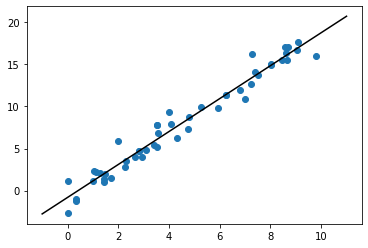

In [8]:
xfit = np.linspace(-1, 11)
Xfit = xfit[:, np.newaxis]
yfit = model.predict(Xfit)

plt.scatter(x, y)
plt.plot(xfit, yfit, 'k');

In [9]:
#Return the R^2 prediction score
print('R^2: '+str(model.score(X, y)))

#Calculate manually
y_pred = model.predict(X)
r2_manual = 1-np.sum((y_pred-y)**2)/np.sum((np.mean(y)-y)**2)

print('R^2 manual: '+str(r2_manual))

#And another way
from scipy.stats import pearsonr
r, p = pearsonr(y_pred, y)
print('r**2: '+str(r**2))

R^2: 0.9634744742842296
R^2 manual: 0.9634744742842296
r**2: 0.9634744742842298


**Exercise: Perform a linear regression to predict petal width from sepal length and septal width in the iris dataset. What is the model performance? (i.e. R^2)**

## Logistic Regression

<img src="https://www.saedsayad.com/images/LogReg_1.png">

### Example: Subject R1111M

First, let's compute spectral power z-scores for all of the encoding events in R1111M's FR1 experiment. We'll use these power values as the basis for classifying good vs. bad memory states.

In [10]:
from CMLLoad import CMLLoad
import numpy as np

# Remember to update this to where your CMLExamples data is located.
load = CMLLoad('./CMLExamples')

# We load the dataframe for all sessions.
df = load.Index()

# Specify which subject and experiment we want
sub = 'R1111M'
exp = 'FR1'

# Select the dataframes for our subject and experiment.
df_select = df[(df['subject']==sub) & (df['experiment']==exp)]

In [11]:
# Instead of just looking at session 1, we want to analyze data from all sessions.
# To do that, we'll use a for loop.

recalled = []  # For storing encoding success.
sess_pows = []  # For storing our computed spectral powers.
sess_num = []

for df_sess in df_select.itertuples():
    sess = df_sess._asdict()['session']
    evs = load.Load(df_sess, 'events')
    word_evs = evs[evs['type']=='WORD']

    buf = 1000  # To remove edge effects during wavelet convolution.
    eeg_ptsa = load.LoadPTSA(df_sess, -buf, buf+1400+buf)
    eeg_ptsa = eeg_ptsa[word_evs.index]

    sr = eeg_ptsa.samplerate
    
    from ptsa.data.filters import ButterworthFilter
    from ptsa.data.filters import MorletWaveletFilter
    
    # Filter out line noise.
    freq_range = [58., 62.]
    b_filter = ButterworthFilter(freq_range=freq_range, filt_type='stop', order=4)
    eeg_filtered = b_filter.filter(eeg_ptsa)
    
    # Get spectral power.
    myfreqs = np.logspace(np.log10(3), np.log10(180), 8)  
    wf = MorletWaveletFilter(freqs=myfreqs, width=5, output='power', cpus=2)
    pow_wavelet = wf.filter(eeg_filtered)   # Output is [freqs, events, elecs, time].
    # Remove buffer period.
    pows = pow_wavelet.data[:, :, :, int((buf/1000.)*sr):-1*int((buf/1000.)*sr)]
    pows = np.log10(pows)
    
    # Average power across the whole interval.
    avg_pows = np.mean(pows, -1)

    from scipy.stats import zscore
    # z-score power values across events (important to do within-session).
    z_pows = zscore(avg_pows, axis=1)
    sess_pows.append(z_pows)

    # We need to store this data across-sessions.
    recalled.extend(list(word_evs['recalled']))
    sess_num.extend(np.ones(len(word_evs))*sess)

    print(str(sess)+' completed successfully!')    
    
z_pows = np.array(z_pows)
recalled = np.array(recalled)
sess_num = np.array(sess_num)
all_pows = np.concatenate(sess_pows, axis=1)

/home1/jrudoler/anaconda3/envs/cml37/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/home1/jrudoler/anaconda3/envs/cml37/lib/python3.7/site-packages/xarray/core/dataarray.py:219: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(data, pd.Panel):


CPP total time wavelet loop:  9.113764524459839
0 completed successfully!
CPP total time wavelet loop:  6.431312561035156
1 completed successfully!
CPP total time wavelet loop:  9.888551712036133
2 completed successfully!
CPP total time wavelet loop:  8.747479677200317
3 completed successfully!


### Preparing the feature matrix

Typically, a feature matrix is a 2D array, with observations as rows and features as columns. You can have as many observations and features as available, but keep in mind that too many features relative to the number of observations can cause issues down the road. If you have many observations and only a handful of features, that should not be a problem. 

Also, it's often good practice to have features standardized/normalized. Since we've already z-scored our powers, no need to do anything new. 

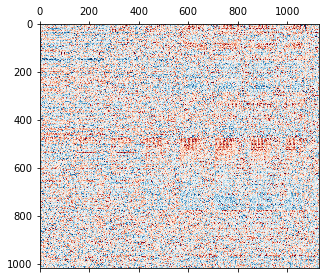

In [12]:
# Convert our power array into a 2D "feature matrix",
# where each row corresponds to a unique event.
pow_feats = all_pows.swapaxes(0, 1).reshape(len(recalled), -1)

# Visualize the feature matrix.
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4.5))
ax = plt.subplot(111)
plt.matshow(pow_feats, aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3, fignum=0)

In [13]:
np.save('R1111M_feature_matrix.npy', pow_feats)
np.save('R1111M_recalled.npy', recalled)
np.save('R1111M_sessions.npy', sess_num)

### Fitting a model on training data: Hyperparameters

Solely for instructional purposes, we're going to do something bad: We're going to train a logistic regression model and test it on the same data. In a real-world machine learning setting, you would almost never do this, because the model will be **overfit** to the training data. That is, it will show a much higher performance than it would in real-world tests on held-out datasets.

Key things to know about fitting a logistic regression model: 

* **Penalty parameter**: The degree to which the model discounts the contribution of each observation, as a first line of defense against overfitting. This is usually called 'C' in sckikit-learn functions. 
* **Regularization method**: The manner in which weights are discounted, called 'penalty' in sckikit-learn. For many purposes in the lab, you may want to use the 'l2' norm, which means that weights are penalized according to their squared magnitude. In other words, the larger the coefficient, the more it will be penalized.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

#How to fit a logistic regression model using scikit-learn
#class_weight helps to adjust for the fact that the number of remembered and not-remembered items are very unequal. 
lr_classifier = LogisticRegression(C=0.0001, penalty='l2', class_weight='balanced', solver='liblinear')
lr_classifier.fit(pow_feats, recalled)

### Computing an AUC and plotting ROC curves

How do we assess how well our classifier is doing? We could simply ask for percent correct -- what proportion of the total items did the classifier guess correctly? The problem with this approach is that it does not account for the different *ways* in which a classifier can be correct or incorrect. What we really want to know is, how well does our classifier *distinguish* between two groups?

The solution is to measure the **area under the receiver operating characteristic curve**. Let's unpack what this means! 

A classifier has: 

* A True Positive Rate (TPR): The rate at which the classifier says "1" when the truth is "1." Also called **sensitivity**.
* A False Positive Rate (FPR): The rate at which the classifier says "1" when the truth is "0." This is captured by 1-**specificity**. 

<br>
<center>
<img src="https://acutecaretesting.org/-/media/acutecaretesting/articles/table-i-comparing-a-method-with-the-clinical-truth.gif?w=300&h=193&as=1&la=en">
</center>
<br>

Ideally, a classifier can fully separate true and false data. That is, it won't say "1" when the truth is a zero, but will say "1" when the truth is a "1". Note that a classifier could correctly identifiy every single "1", but if it's also saying "1" in response to a bunch of zeros, it isn't a very useful classifier! That is, **we want classifiers with high sensitivity (true positives) but also low 1-specificity (false positives).** The ROC is a way of measuring such performance, by **explicitly graphing the tradeoff between sensitivity and specificity at various thresholds.**

<br>
<center>
<table>
    <tr>
        <th><img src="https://cdn-images-1.medium.com/max/1600/1*yF8hvKR9eNfqqej2JnVKzg.png"></th>
        <th><img src="https://cdn-images-1.medium.com/max/800/1*-tPXUvvNIZDbqXP0qqYNuQ.png" width=250></th>
    </tr>
</table>
</center>

As you sweep the threshold across the two distributions, the TPR and FPR are measured at each point, and plotted against each other on 2D axes. After sweeping through the entire range, you're left with an ROC curve -- each point at the end must exist at [0, 0] and [1, 1], because we are either completely guessing "True" or completely  guessing "False." The shape of the curve in the middle tells you how good the classifier is.

The **AUC** is a single number that quantifies the curve's shape. If the AUC is 0.5, that means it lies flat along the diagonal, and our two distributions are overlapping; TPR and FPR are the same at every threshold. If the AUC is 1, that means our two distributions are completely non-overlapping, and a single threshold can perfectly distinguish between them with no errors. (An AUC of zero would mean the classifier is able to distinguish the two classes, but is flipping the label!)

In [ ]:
#scikit-learn makes it very easy to get AUCs and ROCs

recall_prob_array = lr_classifier.predict_proba(pow_feats)[:,1]
auc = roc_auc_score(recalled, recall_prob_array)
print(auc)

In [ ]:
roc_curve_data_train = roc_curve(recalled, recall_prob_array)
fpr_train = roc_curve_data_train[0]  #false positive rate
tpr_train = roc_curve_data_train[1]  #true positive rate

#Plot results
plt.figure(figsize=(3.5, 3))
ax = plt.subplot(111)
plt.plot(fpr_train, tpr_train)
plt.plot((0.0,1.0),(0.,1.),'k--')
plt.xlabel('FPR', fontsize=14)
plt.ylabel('TPR', fontsize=14)
plt.title('Training Data ROC-curve')

**Exercise: How does the ROC curve/AUC change as a function of the penalty parameter?**

**Exercise: Randomly select a subset of features from the feature matrix, and recompute the AUC. How does AUC change as a function of the number of features?**

### Visualizing classifier output

For logistic regression classifier we estimate probabilities that a given event belongs to a a class of recalled events. The probability formula is given by:

$P(x)=\left({1+e^{-\left(B+\sum w_i x_i\right)}}\right)^{-1}$

which implies that we are looking for a dividing hyperplane that will separate recalled and non-recalled events. The equation of this hyperplane is simply

$B+\sum w_i x_i = 0$

where $B$ is the intercept and $w_i$'s are weights coefficients fitted by Logistic Regression algorithm. $x_i$'s are features of the classifier - in our case $x_i$'s denote mean powers for the i-th combination of spectral frequency and bipolar pair. While ROC and AUC can give you a sense of classifier performance, sometimes it is nice to be able to visualize how well the dividing hyperplane separates data points belonging to thtw two classes (here recalled vs non recalled) We can do it by projecting N dimensional space into two dimennsions and plot dividing plane as well as individual , color-coded events. Let's rewrite $B+\sum w_i x_i = 0$ as 

$ B+X+Y = 0 $ where $X = \sum_{i=0}^{i=200} w_i x_i$ and $Y = \sum_{i=201}^{i=N} w_i x_i$. The number 200 is arbitrary here. The idea is that we can treat a weighted sum of first n features as one variable and the weighted sum of the remaining features as another variable and plot those on a scatter plot. Here I picked $n=200$ and $N$ denotes total number of features. Since $ B+X+Y = 0 $ is the exponent in the logistic probability function the line along which the probability of the data point belonging to either class is exactly 0.5 is called dividing line. It is not hard to see that the equation of hte dividing line is exactly 
$ B+X+Y = 0 $
because when the exponent is $0$ then 

$P(x)=\left({1+e^{-0}}\right)^{-1}=0.5$

Now, the data points that lie above the dividing line will get assigned high probability (here, of being recalled) and those that lie below will get assigned low probability

In [ ]:
# Inspect the classifier weights.
w_tmp = np.squeeze(lr_classifier.coef_)
w_tmp

In [ ]:
# For demonstration purposes, take the weighted sum of the first chunk
# of features as X values and last chunk of features for Y values.
# A quick-and-direct dimensionality reduction of the feature space.

# Create an empty weight object with column for intercept and columns
# for classifier-derived weights.
w = np.zeros(len(w_tmp)+1)
w[0] = lr_classifier.intercept_
w[1:] = w_tmp

# Use dot product to get weighted sum of first 200 features as X
# and remaining features as Y.
x_project = np.dot(pow_feats[:,:200], w[1:201])
y_project = np.dot(pow_feats[:,200:], w[201:])
recalled_ind = recalled==0

In [ ]:
# Plot results.
fig = plt.figure(figsize=(6, 6))

x = np.linspace(-0.5,0.5)
plt.plot(x, -w[0]-x)
plt.scatter(x_project[recalled_ind], y_project[recalled_ind], s=80, facecolors='none', edgecolors='r')
plt.scatter(x_project[~recalled_ind], y_project[~recalled_ind], s=80, facecolors='none', edgecolors='b')

# Assignment 5
In this assignment, you will use linear regression to estimate the exponent of the power law for electrodes in R1111M. 
1. Select the first 50 electrodes and computes spectral power using Morlet wavelets for 30 frequencies between 3 and 150 Hz (np.logspace(np.log10(3), np.log10(150), num=30)) using buf = 1000 ms. 
2. Fit a regression of $\log(power) \sim \log(freq)$ for each electrode and obtain an estimate for $\alpha$, where $\alpha$ is the exponent in $ power \sim 1/freq^\alpha$.
3. Plot the distribution of $\alpha$ across these 50 electrodes. How consistent are the $\alpha$'s across these electrodes? 